# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from PIL import Image 
  

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [3]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [4]:
import pandas as pd 
predCombined = pd.read_csv('../input/preds-without-bad-nets/Copy of export_dataframe_pred.xlsx - pred.csv')
predCombined.info()

allPredictions = pd.read_csv('../input/predictions-combined-update/combined_predictions.csv')
allPredictions.info()

thresholdPreds = []
networkNames = ['/kaggle/input/resnet-no-1/resnet101', '/kaggle/input/resnet-no-1/resnet50_2', '/kaggle/input/resnet-no-1-e46ccc/MobileNet', '/kaggle/input/resnet-no-1-e46ccc/MobileNet-2', '/kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3', '/kaggle/input/fork-of-resnet-no-1-training-3/ResNet152', '/kaggle/input/training-all-01/MobileNet-2', '/kaggle/input/training-all-01/MobileNet-3', '/kaggle/input/training-all-01/MobileNet', '/kaggle/input/training-all-01/ResNet152', '/kaggle/input/training-all-00/resnet101', '/kaggle/input/training-all-00/resnet50', '/kaggle/input/training-all-00/resnet50_2', '/kaggle/input/training-all-00/resnet50_3', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet-2', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet-3', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet', '/kaggle/input/training-all-11-layers-trainable-true/ResNet152', '/kaggle/input/training-all-11-layers-trainable-true/ResNet152_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet101', '/kaggle/input/training-all-10-layers-trainable-true/resnet101_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet50', '/kaggle/input/training-all-10-layers-trainable-true/resnet50_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet50_3', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet101_2', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_2', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_3', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-2', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-3', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet', '/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152', '/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152_2']
for i in range (len(allPredictions)):
    for net in networkNames: 
        ind = allPredictions[net][i]
        if ind >= 0.3:
            thresholdPreds.append(1)
        else:
            thresholdPreds.append(0)
#print(thresholdPreds)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 35 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   /kaggle/input/resnet-no-1/resnet101                               590 non-null    int64
 1   /kaggle/input/resnet-no-1/resnet50_2                              590 non-null    int64
 2   /kaggle/input/resnet-no-1-e46ccc/MobileNet                        590 non-null    int64
 3   /kaggle/input/resnet-no-1-e46ccc/MobileNet-2                      590 non-null    int64
 4   /kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3          590 non-null    int64
 5   /kaggle/input/fork-of-resnet-no-1-training-3/ResNet152            590 non-null    int64
 6   /kaggle/input/fork-of-resnet-no-1-training-3/resnet101_2          590 non-null    int64
 7   /kaggle/input/training-all-01/MobileNet-2            

In [5]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_23.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_23_mask.tif


### creating final datset

In [8]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


# 2: DATA VISUALIZATION

In [9]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [10]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

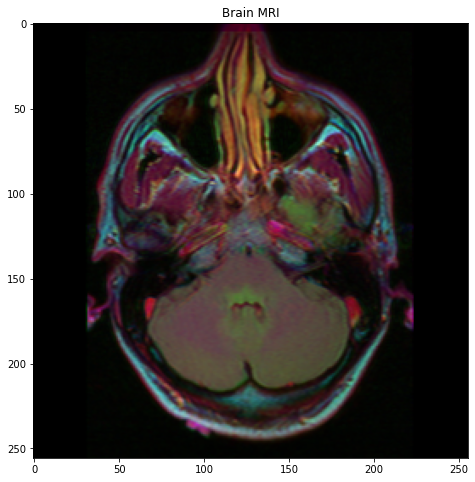

In [11]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Brain MRI')

#plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [12]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

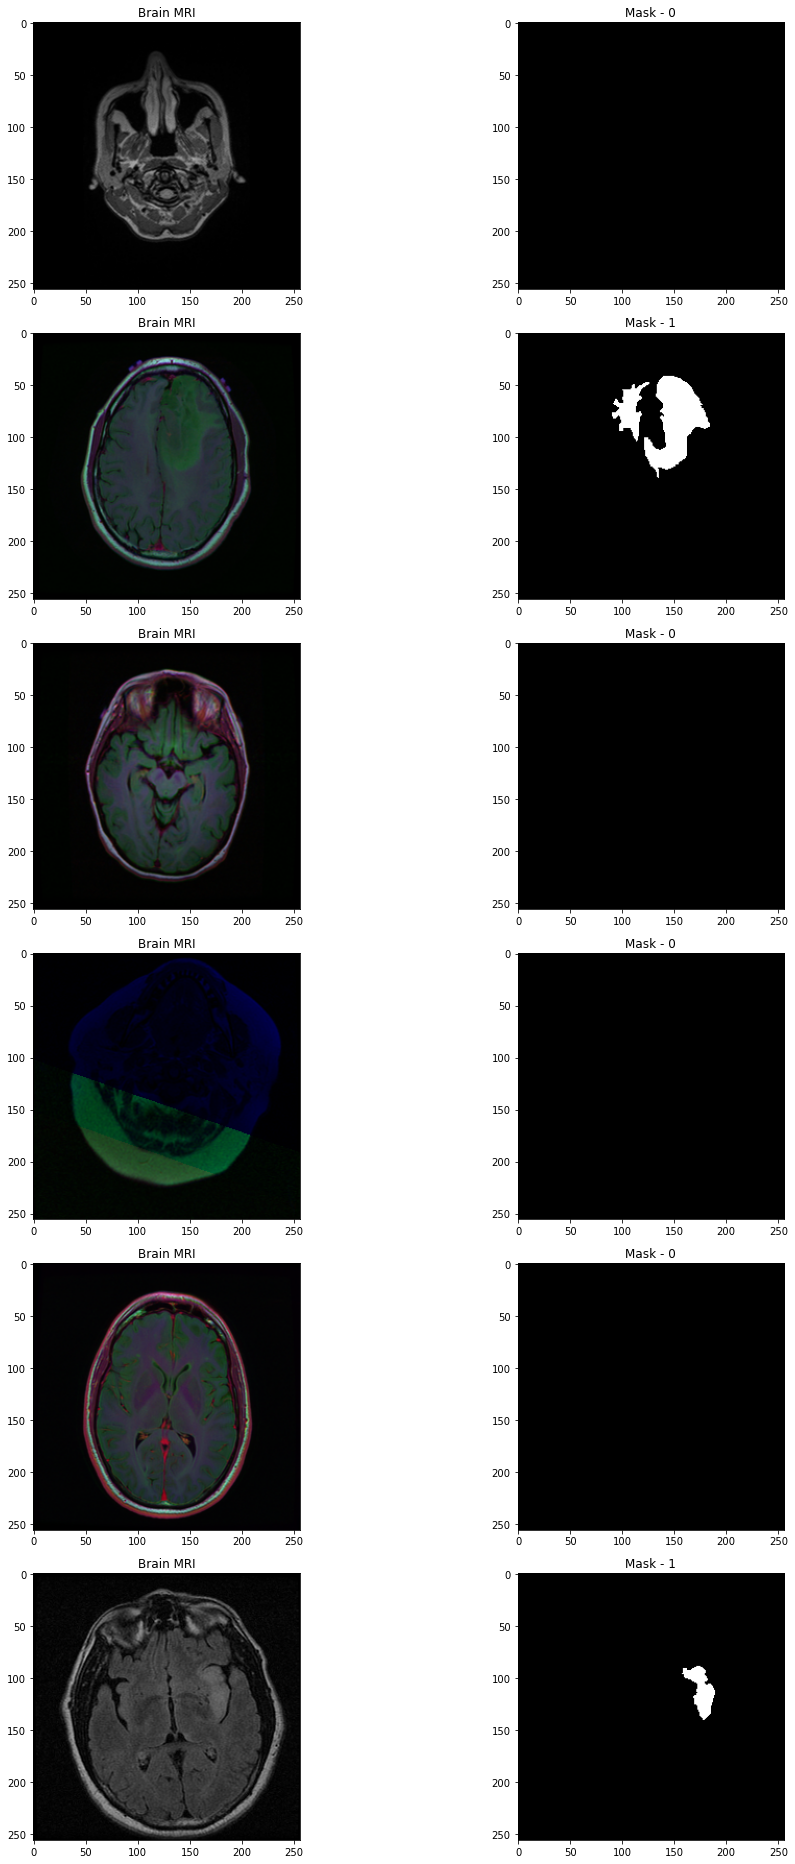

In [13]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

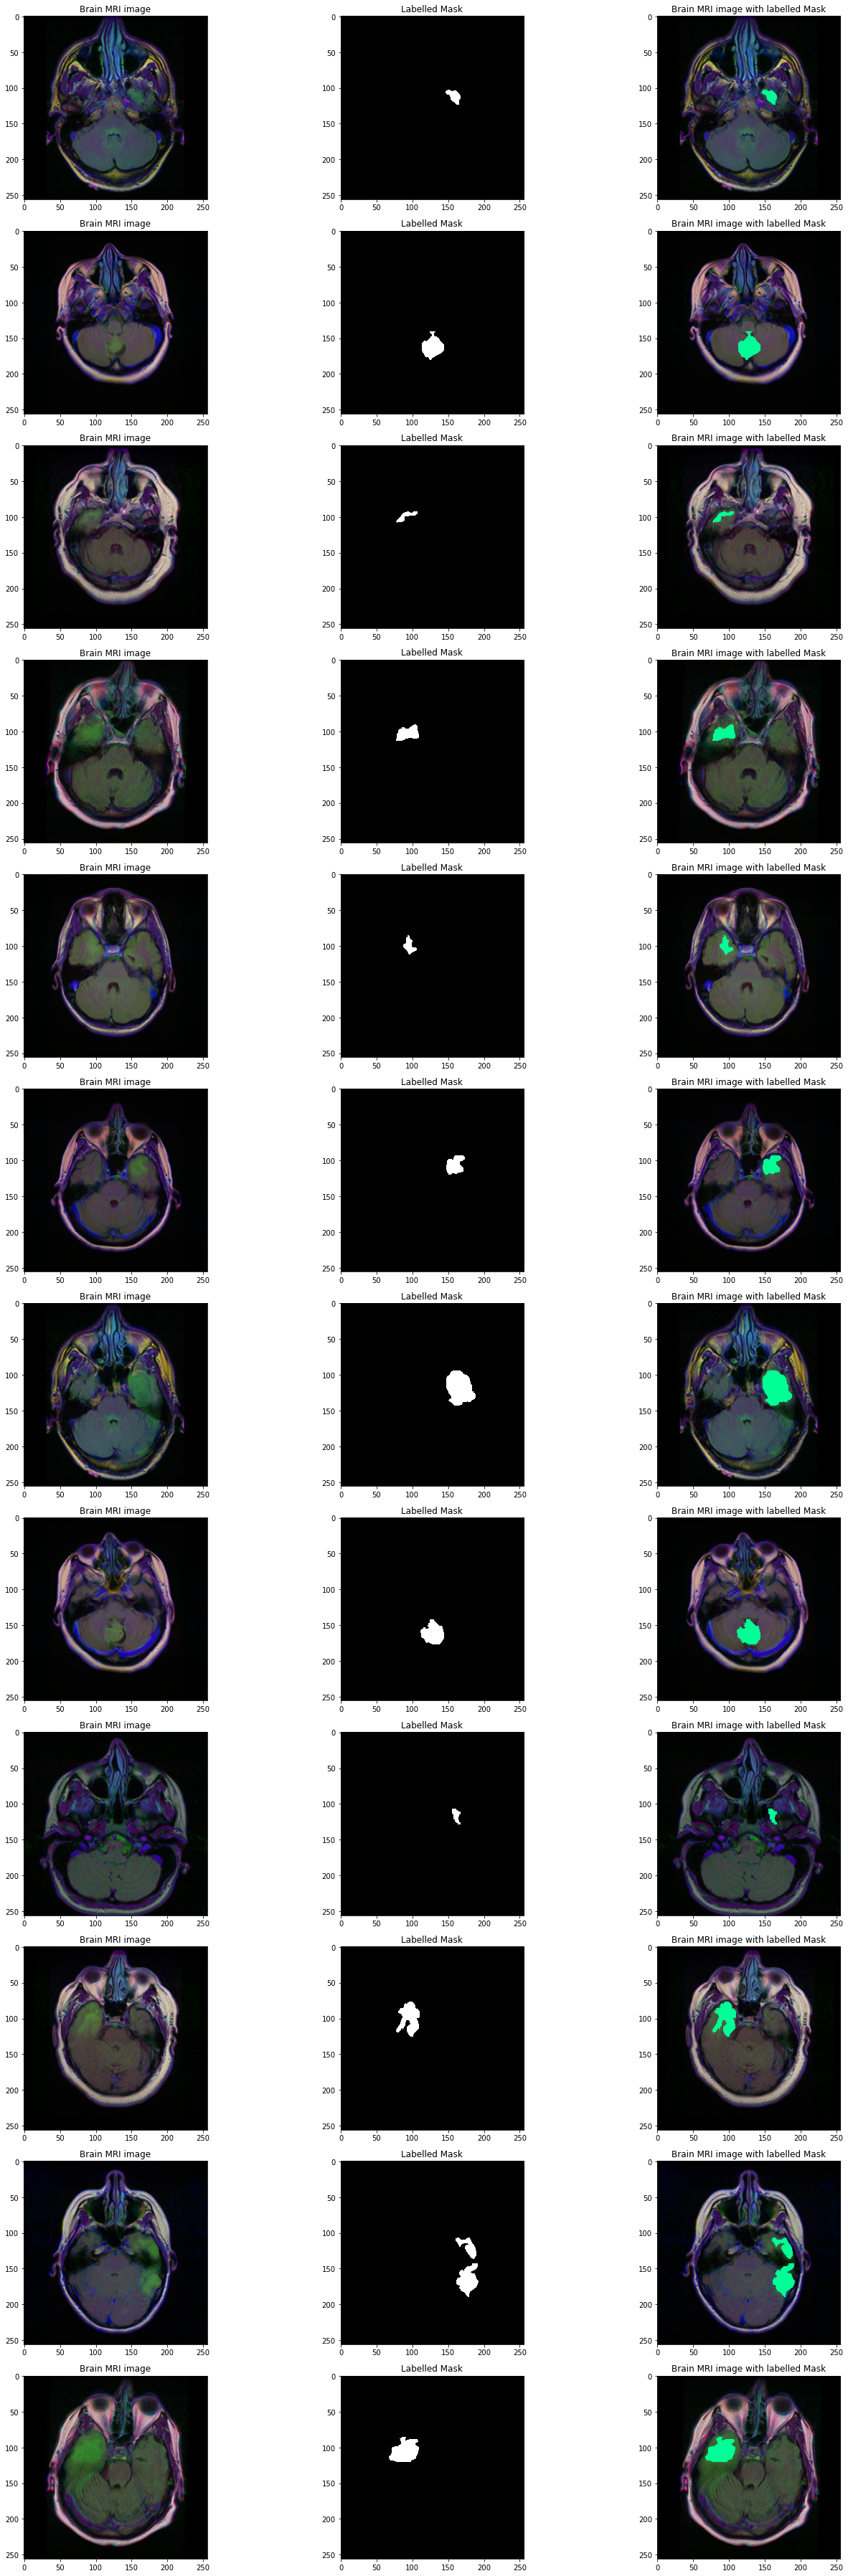

In [14]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI image")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Labelled Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("Brain MRI image with labelled Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# 5: CRETING TEST, TRAIN & VAL SET

In [15]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 123456)
fileNames = test["image_path"]
maskNames = test["mask_path"]
print(maskNames)

1661    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3673    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3656    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2102    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3283    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
                              ...                        
1614    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3526    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2387    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
667     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2557    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
Name: mask_path, Length: 590, dtype: object


In [17]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# 6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [18]:
from tensorflow.keras.applications import ResNet101

In [19]:
!ls
!pwd
!ls /kaggle/input/results
!if [ -d /kaggle/working/my_resnet101 ]; then echo "already exist"; else cp -ra /kaggle/input/results/. . ; fi


__notebook__.ipynb
/kaggle/working
ResUNet-seg-model.json	       clf-resnet101-weights.hdf5  my_resnet101.h5
ResUNet-segModel-weights.hdf5  clf-resnet50-model.json	   my_resnet50
__results___files	       clf-resnet50-weights.hdf5   my_resnet50.h5
clf-resnet101-model.json       my_resnet101


In [20]:
allPreds = []
all_models = []
dfPreds = pd.DataFrame()
import gc

In [21]:
from matplotlib.pyplot import plot
allAcc = []
allSystemAccs = []

allRateFalseNeg = []
networkNames = ['/kaggle/input/resnet-no-1/resnet101', '/kaggle/input/resnet-no-1/resnet50_2', '/kaggle/input/resnet-no-1-e46ccc/MobileNet', '/kaggle/input/resnet-no-1-e46ccc/MobileNet-2', '/kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3', '/kaggle/input/fork-of-resnet-no-1-training-3/ResNet152', '/kaggle/input/training-all-01/MobileNet-2', '/kaggle/input/training-all-01/MobileNet-3', '/kaggle/input/training-all-01/MobileNet', '/kaggle/input/training-all-01/ResNet152', '/kaggle/input/training-all-00/resnet101', '/kaggle/input/training-all-00/resnet50', '/kaggle/input/training-all-00/resnet50_2', '/kaggle/input/training-all-00/resnet50_3', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet-2', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet-3', '/kaggle/input/training-all-11-layers-trainable-true/MobileNet', '/kaggle/input/training-all-11-layers-trainable-true/ResNet152', '/kaggle/input/training-all-11-layers-trainable-true/ResNet152_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet101', '/kaggle/input/training-all-10-layers-trainable-true/resnet101_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet50', '/kaggle/input/training-all-10-layers-trainable-true/resnet50_2', '/kaggle/input/training-all-10-layers-trainable-true/resnet50_3', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet101_2', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_2', '/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_3', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-2', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-3', '/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet', '/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152', '/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152_2']
original = np.asarray(test['mask']).astype('int')
sumnetlist = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
numSystems = 9
numSystemsTotal = len(networkNames)
 
allNetaccuracyStat = []    
allNetFalseNegs = []
allNetFalsePos = []
allNetTrueNegs = []
allNetTruePos = []
allNetNegCount = []
allNetPosCount = []
allNetSpecificity = []
allNetSensitivity = []
allNetFNR = []

allSystemFalseNeg = []
allSystemSpecificity = []
allSystemSensitivity = []
allSystemFNR = []

random.seed(6)
for h in range(10):
    networksUsedInSystem = []
    for j in range(numSystems):
        newInt = random.randint(0, numSystemsTotal-1)
        if newInt not in networksUsedInSystem:
            networksUsedInSystem.append(newInt)
        else:
            newInt = random.randint(0, numSystemsTotal-1)
            while newInt in networksUsedInSystem:
                newInt = random.randint(0, numSystemsTotal-1)
            networksUsedInSystem.append(newInt)
    
    systemAccs = []
    systemFalseNeg = []
    systemSpecificity = []
    systemSensitivity = []
    systemFNR = []

    accuracyStat = []
    rateFalseNegs = []
    netTrueNeg = []
    netTruePos = []
    netFalseNeg = []
    netFalsePos = []
    netNegCount = []
    netPosCount = []
    netSpecificity = []
    netSensitivity = []
    netFNR = []

    for net in networksUsedInSystem:
        numWrong = 0
        numFalseNeg = 0
        numFalsePos = 0
        numTruePos = 0
        numTrueNeg = 0
        negCount = 0
        posCount = 0
        for i in range(len(original)):
            if original[i] == 1 and predCombined[networkNames[net]][i] == 0:
                numFalseNeg += 1
            if original[i] == 0 and predCombined[networkNames[net]][i] == 1:
                numFalsePos += 1
            if original[i] != predCombined[networkNames[net]][i]:
                numWrong += 1
            if original[i] == 1 and predCombined[networkNames[net]][i] == 1:
                numTruePos += 1
            if original[i] == 0 and predCombined[networkNames[net]][i] == 0:
                numTrueNeg += 1
            if original[i] == 0:
                negCount += 1
            if original[i] == 1:
                posCount += 1

        # individual nets: numTrueNeg (each net) -> netTrueNeg (9 nets) -> allNetTrueNegs (10 runs)
        # append each net's results to the list of 9 nets
        accuracyStat.append((len(original) - numWrong)/(len(original))*100)
        netTrueNeg.append(numTrueNeg)
        netTruePos.append(numTruePos)
        netFalseNeg.append(numFalseNeg)
        netFalsePos.append(numFalsePos)
        netNegCount.append(negCount) 
        netPosCount.append(posCount)
        
        #individual net's specificity and sensitivity fixme
        netSpecificity.append(numTrueNeg/(numTrueNeg + numFalsePos)*100)
        netSensitivity.append(numTruePos/(numTruePos + numFalseNeg)*100) 
        netFNR.append(numFalseNeg/(numFalseNeg + numTruePos)*100) 
            
    # append each 9 net's individual results to the list of 10 runs
    allNetaccuracyStat.append(accuracyStat)
    allNetFalseNegs.append(netFalseNeg)
    allNetFalsePos.append(netFalsePos)
    allNetTrueNegs.append(netTrueNeg)
    allNetTruePos.append(netTruePos)
    
    allNetNegCount.append(netNegCount)
    allNetPosCount.append(netPosCount)
    
    allNetSensitivity.append(netSensitivity)
    allNetSpecificity.append(netSpecificity)
    allNetFNR.append(netFNR)

    sumAvg = 0
    cutAcc = []
    for acc in accuracyStat:
        sumAvg += acc
        cutAcc.append(round(acc, 5))
        
    sumAvg = sumAvg / numSystems

    print("Accuracy of each network: ", cutAcc)
    allAcc.append(cutAcc)
    print("Average Accuracy of networks: ", (round(sumAvg, 5)))
    print("networksUsedInSystem", networksUsedInSystem)
#    print("Number of false negatives in each network: ", netFalseNeg)
#    print("Rate of false negatives: ", rateFalseNegs, "%")
#    print("----------------------------------")
    
    for x in sumnetlist:
                
        print("sumnet ", int(x))
        
        # sumnet system results calculation
        finalResult = []

        for i in range (len(predCombined)):
            sumnet = 0
            for net in networksUsedInSystem:
                network = networkNames[net] 
                individual = predCombined[network][i]
                sumnet += individual
            # finalresult of the system is positive if >=x nets say positive     
            if (sumnet >= x):
                finalResult.append(1)
            else:
                finalResult.append(0)

        original = np.asarray(test['mask']).astype('int')
        sysnumFalseNegatives = 0
        sysnumTruePositives = 0
        sysnumTrueNegatives = 0
        sysnumFalsePositives = 0
        sysnumTotalWrong = 0
        for n in range(len(original) - 1):
            if original[n] == 1 and finalResult[n] == 0:
                sysnumFalseNegatives += 1
                # print("False Negative ", n)
            if original[n] == 1 and finalResult[n] == 1:
                sysnumTruePositives += 1
            if original[n] == 0 and finalResult[n] == 0:
                sysnumTrueNegatives += 1
            if original[n] == 0 and finalResult[n] == 1:
                sysnumFalsePositives += 1
            if original[n] != finalResult[n]:
                sysnumTotalWrong += 1
                         
                                                                  
        systemAcc = round((len(predCombined) - sysnumTotalWrong)/(len(predCombined)), 5)*100
        print("# False Neg in entire system", "# Total Wrong in entire system", "System Accuracy   ", sysnumFalseNegatives, "       ", sysnumTotalWrong, "       ", str(systemAcc))
        systemAccs.append(systemAcc)

        systemFalseNeg.append(sysnumFalseNegatives)
        systemSpecificity.append(sysnumTrueNegatives/(sysnumTrueNegatives + sysnumFalsePositives)*100)
        systemSensitivity.append(sysnumTruePositives/(sysnumTruePositives + sysnumFalseNegatives)*100)           
        systemFNR.append(sysnumFalseNegatives/(sysnumFalseNegatives + sysnumTruePositives)*100)

                
    allSystemFalseNeg.append(systemFalseNeg)      
    allSystemAccs.append(systemAccs)
    allSystemSpecificity.append(systemSpecificity)
    allSystemSensitivity.append(systemSensitivity)
    allSystemFNR.append(systemFNR)
    


Accuracy of each network:  [95.25424, 96.94915, 97.28814, 96.77966, 94.23729, 95.59322, 96.44068, 93.55932, 97.79661]
Average Accuracy of networks:  95.9887
networksUsedInSystem [5, 31, 16, 2, 0, 9, 30, 23, 20]
sumnet  1
# False Neg in entire system # Total Wrong in entire system System Accuracy    1         46         92.203
sumnet  2
# False Neg in entire system # Total Wrong in entire system System Accuracy    2         13         97.797
sumnet  3
# False Neg in entire system # Total Wrong in entire system System Accuracy    6         10         98.30499999999999
sumnet  4
# False Neg in entire system # Total Wrong in entire system System Accuracy    8         10         98.30499999999999
sumnet  5
# False Neg in entire system # Total Wrong in entire system System Accuracy    9         11         98.136
sumnet  6
# False Neg in entire system # Total Wrong in entire system System Accuracy    17         19         96.78
Accuracy of each network:  [97.62712, 95.08475, 96.94915, 97.2881

In [22]:
allSystemsLabels=['ThreshNet=1','ThreshNet=2', 'ThreshNet=3', 'ThreshNet=4', 'ThreshNet=5', 'ThreshNet=6']
print(allSystemsLabels)
allSystemsMarkers=['ro-', 'gv-', 'b^-', 'ys-', 'm*-', 'cd-']

['ThreshNet=1', 'ThreshNet=2', 'ThreshNet=3', 'ThreshNet=4', 'ThreshNet=5', 'ThreshNet=6']


[[92.203 97.797 98.305 98.305 98.136 96.78 ]
 [91.356 96.271 97.797 98.475 98.136 98.136]
 [91.864 96.61  98.305 98.475 98.644 98.136]
 [93.22  97.288 98.136 98.305 97.797 97.288]
 [90.508 96.271 98.136 98.305 98.136 97.966]
 [91.864 97.627 98.475 98.305 97.797 96.949]
 [92.034 97.119 97.797 97.966 97.966 97.458]
 [90.508 96.441 98.475 98.305 97.797 97.119]
 [91.695 96.271 97.966 98.136 98.305 98.136]
 [93.729 97.119 98.136 98.644 97.966 97.458]]


Text(0, 0.5, 'Accuracy (percentage)')

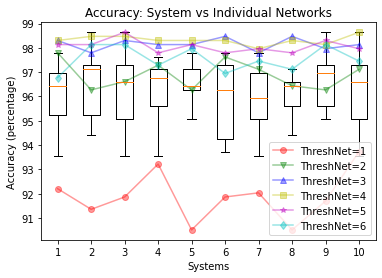

In [23]:
# Box plots of 10 networks that make up each system 
accuracyPlot = plt.boxplot(allAcc)


xArray=[]
for i in range(len(allAcc)):
    #y = allAcc[i]
    y = allSystemAccs[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    # plot(x, y, 'ro', alpha=0.4)

allSystemAccs = np.array(allSystemAccs)
print(allSystemAccs)
x = range(1, len(allAcc)+1)
for i in range(len(allSystemsLabels)):
    plot(x, allSystemAccs[: , i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)
plt.legend() 
plt.title('Accuracy: System vs Individual Networks')
plt.xlabel('Systems')
plt.ylabel('Accuracy (percentage)')
    

[[1, 2, 6, 8, 9, 17], [0, 3, 4, 6, 8, 9], [0, 3, 4, 6, 6, 9], [2, 4, 7, 7, 10, 13], [2, 3, 4, 7, 8, 10], [3, 5, 6, 8, 11, 16], [3, 3, 7, 9, 9, 14], [2, 3, 5, 7, 11, 15], [1, 3, 4, 7, 8, 10], [1, 4, 6, 6, 10, 13]]


Text(0, 0.5, 'Num False Negatives (Count)')

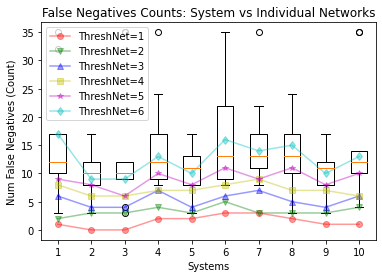

In [24]:
allSystemsNegStat = []
for neg in allNetFalseNegs:
    systemsNegStat = []
    for n in neg:
        rateFalseNeg =  n/(n + numTruePos) * 100
        systemsNegStat.append(rateFalseNeg)   
    allSystemsNegStat.append(systemsNegStat)
    
    #--------------------------------------------
    
print(allSystemFalseNeg)
    
falseNegPlot = plt.boxplot(allNetFalseNegs)

for i in range(len(allSystemsNegStat)):
    y=allSystemsNegStat[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))

allSystemFalseNegs = np.array(allSystemFalseNeg)
x = range(1, len(allNetFalseNegs)+1)

for i in range(len(allSystemsLabels)):
    plot(x, allSystemFalseNegs[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)
    #plot(x, y, 'ro', alpha=0.4)
plt.legend() 
plt.title('False Negatives Counts: System vs Individual Networks')
plt.xlabel('Systems')
plt.ylabel('Num False Negatives (Count)')

[[88.69346734 97.2361809  98.99497487 99.49748744 99.49748744 99.49748744]
 [87.18592965 95.22613065 97.73869347 99.24623116 99.24623116 99.49748744]
 [87.93969849 95.72864322 98.49246231 99.24623116 99.49748744 99.49748744]
 [90.45226131 96.98492462 98.99497487 99.24623116 99.24623116 99.24623116]
 [86.4321608  95.22613065 98.24120603 99.24623116 99.24623116 99.49748744]
 [88.69346734 97.73869347 99.24623116 99.49748744 99.49748744 99.49748744]
 [88.94472362 96.48241206 98.49246231 99.24623116 99.24623116 99.74874372]
 [86.4321608  95.47738693 98.99497487 99.24623116 99.49748744 99.49748744]
 [87.93969849 95.22613065 97.98994975 98.99497487 99.49748744 99.74874372]
 [90.95477387 96.73366834 98.74371859 99.49748744 99.49748744 99.49748744]]


Text(0, 0.5, 'Specificity (percentage)')

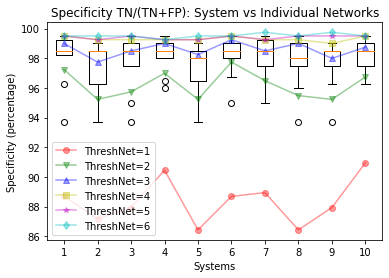

In [25]:
# Specificity Box and Whisker Plot
plt.boxplot(allNetSpecificity)
allSystemSpecificity = np.array(allSystemSpecificity)
print(allSystemSpecificity)
x = range(1, len(allSystemSpecificity)+1)

# system plot
for i in range(len(allSystemsLabels)):
    plot(x, allSystemSpecificity[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)

plt.legend()
plt.title('Specificity TN/(TN+FP): System vs Individual Networks')
plt.xlabel('Systems')
plt.ylabel('Specificity (percentage)')


[[ 99.47643979  98.95287958  96.85863874  95.81151832  95.28795812
   91.09947644]
 [100.          98.42931937  97.90575916  96.85863874  95.81151832
   95.28795812]
 [100.          98.42931937  97.90575916  96.85863874  96.85863874
   95.28795812]
 [ 98.95287958  97.90575916  96.33507853  96.33507853  94.76439791
   93.19371728]
 [ 98.95287958  98.42931937  97.90575916  96.33507853  95.81151832
   94.76439791]
 [ 98.42931937  97.38219895  96.85863874  95.81151832  94.2408377
   91.62303665]
 [ 98.42931937  98.42931937  96.33507853  95.28795812  95.28795812
   92.67015707]
 [ 98.95287958  98.42931937  97.38219895  96.33507853  94.2408377
   92.14659686]
 [ 99.47643979  98.42931937  97.90575916  96.33507853  95.81151832
   94.76439791]
 [ 99.47643979  97.90575916  96.85863874  96.85863874  94.76439791
   93.19371728]]
[[ 99.47643979  98.95287958  96.85863874  95.81151832  95.28795812
   91.09947644]
 [100.          98.42931937  97.90575916  96.85863874  95.81151832
   95.28795812]
 [100

Text(0, 0.5, 'Sensitivity (percentage)')

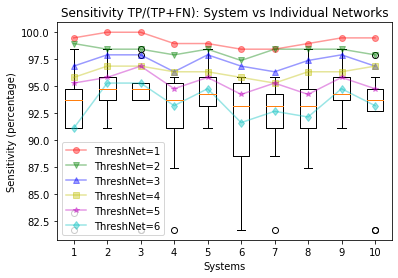

In [26]:
# Sensitivity Box and Whisker Plot
plt.boxplot(allNetSensitivity)
allSystemSensitivity = np.array(allSystemSensitivity)
print(allSystemSensitivity)
x = range(1, len(allSystemSensitivity)+1)

print(allSystemSensitivity)

# system plot
for i in range(len(allSystemsLabels)):
    plot(x, allSystemSensitivity[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)

plt.legend()
plt.title('Sensitivity TP/(TP+FN): System vs Individual Networks')
plt.xlabel('Systems')
plt.ylabel('Sensitivity (percentage)')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1aca9c4a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1aca9c4850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1aca97ded0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1aca9c1fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1aca9c1d10>,
 'means': []}

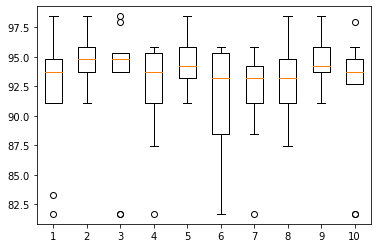

In [27]:
plt.boxplot(allNetSensitivity)


[[0.52356021 1.04712042 3.14136126 4.18848168 4.71204188 8.90052356]
 [0.         1.57068063 2.09424084 3.14136126 4.18848168 4.71204188]
 [0.         1.57068063 2.09424084 3.14136126 3.14136126 4.71204188]
 [1.04712042 2.09424084 3.66492147 3.66492147 5.23560209 6.80628272]
 [1.04712042 1.57068063 2.09424084 3.66492147 4.18848168 5.23560209]
 [1.57068063 2.61780105 3.14136126 4.18848168 5.7591623  8.37696335]
 [1.57068063 1.57068063 3.66492147 4.71204188 4.71204188 7.32984293]
 [1.04712042 1.57068063 2.61780105 3.66492147 5.7591623  7.85340314]
 [0.52356021 1.57068063 2.09424084 3.66492147 4.18848168 5.23560209]
 [0.52356021 2.09424084 3.14136126 3.14136126 5.23560209 6.80628272]]


Text(0, 0.5, 'False Negative Rate (percentage)')

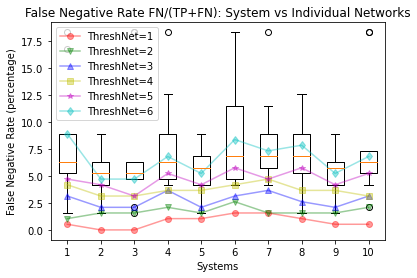

In [28]:
# Miss Rate (FNR) Box and Whisker Plot
plt.boxplot(allNetFNR)
allSystemFNR = np.array(allSystemFNR)
print(allSystemFNR)
x = range(1, len(allSystemFNR)+1)

# system plot
for i in range(len(allSystemsLabels)):
    plot(x, allSystemFNR[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)

plt.legend()
plt.title('False Negative Rate FN/(TP+FN): System vs Individual Networks')
plt.xlabel('Systems')
plt.ylabel('False Negative Rate (percentage)')


In [29]:
from numpy import mean
allNetaccuracyStat_np = np.array(allNetaccuracyStat)
allNetFalseNegs_np = np.array(allNetFalseNegs)
allNetFNR_np = np.array(allNetFNR)
allNetSensitivity_np = np.array(allNetSensitivity)
allNetSpecificity_np = np.array(allNetSpecificity)

bestaccuracy_net_accuracy = []
bestaccuracy_net_sensitivity = []
bestaccuracy_net_specificity = []
bestsensitivity_net_accuracy = []
bestsensitivity_net_sensitivity = []
bestsensitivity_net_specificity = []
bestspecificity_net_accuracy = []
bestspecificity_net_sensitivity = []
bestspecificity_net_specificity = []

for i in range(10):
    bestaccuracy_net = np.argmax(allNetaccuracyStat_np[i]) #fixme
    bestsensitivity_net = np.argmax(allNetSensitivity_np[i])
    bestspecificity_net = np.argmax(allNetSpecificity_np[i])
    print("allNetaccuracyStat[:,", i,"]:",allNetaccuracyStat_np[i], "average:", mean(allNetaccuracyStat_np[i]), "min", min(allNetaccuracyStat_np[i]), "max",max(allNetaccuracyStat_np[i]))
    print("best accuracy net: ",bestaccuracy_net, "Netaccuracy:",allNetaccuracyStat_np[i,bestaccuracy_net])
    print("allSystemAccs[:,", i,"]:",allSystemAccs[i])
    print("")
    print("allNetFalseNegs[:,", i,"]:",allNetFalseNegs_np[i], "average:", mean(allNetFalseNegs_np[i]), "min", min(allNetFalseNegs_np[i]), "max",max(allNetFalseNegs_np[i]))
    print("best accuracy net: ",bestaccuracy_net, "NetFalseNegs:",allNetFalseNegs_np[i,bestaccuracy_net])
    print("allSystemFalseNeg[:,", i,"]:",allSystemFalseNeg[i])
    print("")
    print("allNetFNR[:,", i,"]:",allNetFNR_np[i], "average:", mean(allNetFNR_np[i]), "min", min(allNetFNR_np[i]), "max",max(allNetFNR_np[i]))
    print("best accuracy net: ",bestaccuracy_net, "NetFNR:",allNetFNR_np[i,bestaccuracy_net])
    print("allSystemFNR[:,", i,"]:",allSystemFNR[i])
    print("")
    print("allNetSensitivity[:,", i,"]:",allNetSensitivity_np[i], "average:", mean(allNetSensitivity_np[i]), "min", min(allNetSensitivity_np[i]), "max",max(allNetSensitivity_np[i]))
    print("best accuracy net: ",bestaccuracy_net, "NetSensitivity:",allNetSensitivity_np[i,bestaccuracy_net])
    print("allSystemSensitivity[:,", i,"]:",allSystemSensitivity[i])
    print("")
    print("allNetSpecificity[:,", i,"]:",allNetSpecificity_np[i], "average:", mean(allNetSpecificity_np[i]), "min", min(allNetSpecificity_np[i]), "max",max(allNetSpecificity_np[i]))
    print("best accuracy net: ",bestaccuracy_net, "NetSpecificity:",allNetSpecificity_np[i,bestaccuracy_net])
    print("allSystemSpecificity[:,", i,"]:",allSystemSpecificity[i])
    print("")
    bestaccuracy_net_accuracy.append(allNetaccuracyStat_np[i,bestaccuracy_net])
    bestaccuracy_net_sensitivity.append(allNetSensitivity_np[i,bestaccuracy_net])
    bestaccuracy_net_specificity.append(allNetSpecificity_np[i,bestaccuracy_net])
    bestsensitivity_net_accuracy.append(allNetaccuracyStat_np[i,bestsensitivity_net])
    bestsensitivity_net_sensitivity.append(allNetSensitivity_np[i,bestsensitivity_net])
    bestsensitivity_net_specificity.append(allNetSpecificity_np[i,bestsensitivity_net])
    bestspecificity_net_accuracy.append(allNetaccuracyStat_np[i,bestspecificity_net])
    bestspecificity_net_sensitivity.append(allNetSensitivity_np[i,bestspecificity_net])
    bestspecificity_net_specificity.append(allNetSpecificity_np[i,bestspecificity_net])


allNetaccuracyStat[:, 0 ]: [95.25423729 96.94915254 97.28813559 96.77966102 94.23728814 95.59322034
 96.44067797 93.55932203 97.79661017] average: 95.98870056497175 min 93.55932203389831 max 97.79661016949153
best accuracy net:  8 Netaccuracy: 97.79661016949153
allSystemAccs[:, 0 ]: [92.203 97.797 98.305 98.305 98.136 96.78 ]

allNetFalseNegs[:, 0 ]: [ 3 12 10 12 32 11 17 35 10] average: 15.777777777777779 min 3 max 35
best accuracy net:  8 NetFalseNegs: 10
allSystemFalseNeg[:, 0 ]: [1, 2, 6, 8, 9, 17]

allNetFNR[:, 0 ]: [ 1.57068063  6.28272251  5.23560209  6.28272251 16.7539267   5.7591623
  8.90052356 18.32460733  5.23560209] average: 8.260616637579988 min 1.5706806282722512 max 18.32460732984293
best accuracy net:  8 NetFNR: 5.2356020942408374
allSystemFNR[:, 0 ]: [0.52356021 1.04712042 3.14136126 4.18848168 4.71204188 8.90052356]

allNetSensitivity[:, 0 ]: [98.42931937 93.71727749 94.76439791 93.71727749 83.2460733  94.2408377
 91.09947644 81.67539267 94.76439791] average: 91.7393

In [30]:
print(min(min(allNetSensitivity)))
print(max(max(allNetSensitivity)))
print(min(min(allNetSpecificity)))
print(max(max(allNetSpecificity)))
print(min(min(allNetaccuracyStat)))
print(max(max(allNetaccuracyStat)))

81.67539267015707
98.42931937172776
93.734335839599
99.49874686716792
93.55932203389831
98.64406779661017


Text(0, 0.5, 'Networks Sensitivity statistics (percentage)')

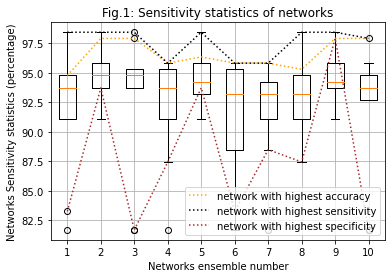

In [31]:
plt.boxplot(allNetSensitivity)
bestaccuracy_net_sensitivity = np.array(bestaccuracy_net_sensitivity)
bestsensitivity_net_sensitivity = np.array(bestsensitivity_net_sensitivity)
bestspecificity_net_sensitivity = np.array(bestspecificity_net_sensitivity)

plot(x,bestaccuracy_net_sensitivity, color='orange', linestyle='dotted', label="network with highest accuracy")
plot(x,bestsensitivity_net_sensitivity, color='black',linestyle='dotted', label="network with highest sensitivity")
plot(x,bestspecificity_net_sensitivity, color ='brown',linestyle='dotted', label="network with highest specificity")
plt.grid()
plt.legend()
plt.title('Fig.1: Sensitivity statistics of networks')
plt.xlabel('Networks ensemble number')
plt.ylabel('Networks Sensitivity statistics (percentage)')

[[93.734335839599, 98.49624060150376, 98.49624060150376, 98.24561403508771, 99.49874686716792, 96.2406015037594, 98.99749373433583, 99.24812030075188, 99.24812030075188], [98.49624060150376, 96.2406015037594, 98.49624060150376, 98.99749373433583, 98.99749373433583, 97.99498746867168, 98.49624060150376, 93.734335839599, 95.98997493734336], [99.49874686716792, 93.734335839599, 99.24812030075188, 98.99749373433583, 98.49624060150376, 97.4937343358396, 97.99498746867168, 98.99749373433583, 94.9874686716792], [97.99498746867168, 98.24561403508771, 98.99749373433583, 99.24812030075188, 98.49624060150376, 96.49122807017544, 98.49624060150376, 99.49874686716792, 95.98997493734336], [97.99498746867168, 98.49624060150376, 98.49624060150376, 93.734335839599, 96.49122807017544, 98.99749373433583, 96.2406015037594, 97.4937343358396, 98.99749373433583], [96.74185463659147, 98.74686716791979, 98.49624060150376, 99.49874686716792, 98.99749373433583, 94.9874686716792, 98.49624060150376, 99.498746867167

Text(0, 0.5, 'Networks specificity statistics (percentage)')

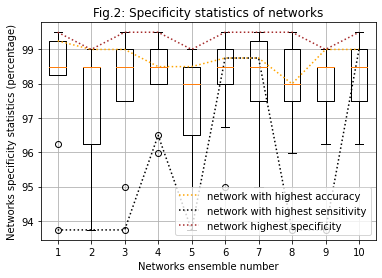

In [32]:
print(allNetSpecificity)
plt.boxplot(allNetSpecificity)
bestaccuracy_net_specificity = np.array(bestaccuracy_net_specificity)
bestsensitivity_net_specificity = np.array(bestsensitivity_net_specificity)
bestspecificity_net_specificity = np.array(bestspecificity_net_specificity)
plot(x,bestaccuracy_net_specificity,color='orange', linestyle='dotted', label="network with highest accuracy")
plot(x,bestsensitivity_net_specificity, color='black', linestyle='dotted', label="network with highest sensitivity")
plot(x,bestspecificity_net_specificity, color='brown', linestyle='dotted', label="network highest specificity")
plt.grid()
plt.legend()
plt.title('Fig.2: Specificity statistics of networks')
plt.xlabel('Networks ensemble number')
plt.ylabel('Networks specificity statistics (percentage)')

Text(0, 0.5, 'Networks accuracy statistics (percentage)')

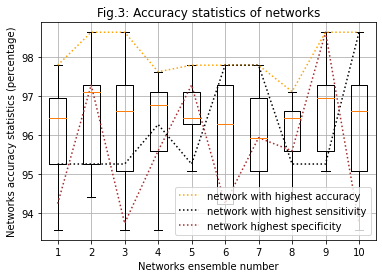

In [33]:
plt.boxplot(allAcc)

plot(x,bestaccuracy_net_accuracy, color='orange', linestyle='dotted', label="network with highest accuracy")
plot(x,bestsensitivity_net_accuracy,color='black', linestyle='dotted', label="network with highest sensitivity")
plot(x,bestspecificity_net_accuracy, color='brown', linestyle='dotted', label="network highest specificity")
plt.grid()
plt.legend()
plt.title('Fig.3: Accuracy statistics of networks')
plt.xlabel('Networks ensemble number')
plt.ylabel('Networks accuracy statistics (percentage)')

[94.76439791 97.90575916 97.90575916 95.81151832 96.33507853 95.81151832
 95.81151832 95.28795812 97.90575916 97.90575916]
[98.42931937 98.42931937 98.42931937 95.81151832 98.42931937 95.81151832
 95.81151832 98.42931937 98.42931937 97.90575916]
[83.2460733  93.71727749 81.67539267 87.43455497 93.71727749 83.2460733
 88.48167539 87.43455497 97.90575916 81.67539267]
[[ 99.47643979  98.95287958  96.85863874  95.81151832  95.28795812
   91.09947644]
 [100.          98.42931937  97.90575916  96.85863874  95.81151832
   95.28795812]
 [100.          98.42931937  97.90575916  96.85863874  96.85863874
   95.28795812]
 [ 98.95287958  97.90575916  96.33507853  96.33507853  94.76439791
   93.19371728]
 [ 98.95287958  98.42931937  97.90575916  96.33507853  95.81151832
   94.76439791]
 [ 98.42931937  97.38219895  96.85863874  95.81151832  94.2408377
   91.62303665]
 [ 98.42931937  98.42931937  96.33507853  95.28795812  95.28795812
   92.67015707]
 [ 98.95287958  98.42931937  97.38219895  96.3350785

Text(0, 0.5, 'Sensitivity statistics (percentage)')

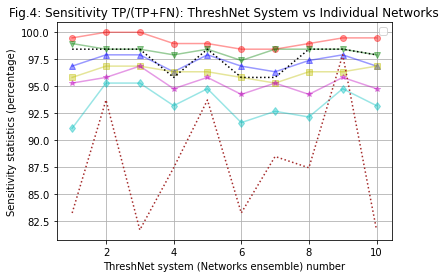

In [34]:
print(bestaccuracy_net_sensitivity)
print(bestsensitivity_net_sensitivity)
print(bestspecificity_net_sensitivity)

allSystemSensitivity = np.array(allSystemSensitivity)
print(allSystemSensitivity)
# system plot
for i in range(len(allSystemsLabels)):
#    plot(x, allSystemSensitivity[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)
    plot(x, allSystemSensitivity[:, i], allSystemsMarkers[i], alpha=0.4)

#plot(x,bestaccuracy_net_sensitivity, color='orange', linestyle='dotted', label="ind. network w/ highest accuracy")
plot(x,bestsensitivity_net_sensitivity,color='black', linestyle='dotted')#,label="ind. network w/ highest sensitivity")
plot(x,bestspecificity_net_sensitivity,color='brown', linestyle='dotted')#,label="ind. network w/ highest specificity")

plt.grid()
plt.legend()
plt.title('Fig.4: Sensitivity TP/(TP+FN): ThreshNet System vs Individual Networks')
plt.xlabel('ThreshNet system (Networks ensemble) number')
plt.ylabel('Sensitivity statistics (percentage)')


[99.2481203  98.99749373 98.99749373 98.4962406  98.4962406  98.74686717
 98.74686717 97.99498747 98.99749373 98.99749373]
[93.73433584 93.73433584 93.73433584 96.49122807 93.73433584 98.74686717
 98.74686717 93.73433584 93.73433584 98.99749373]
[99.49874687 98.99749373 99.49874687 99.49874687 98.99749373 99.49874687
 99.49874687 99.49874687 98.99749373 99.49874687]
[[88.69346734 97.2361809  98.99497487 99.49748744 99.49748744 99.49748744]
 [87.18592965 95.22613065 97.73869347 99.24623116 99.24623116 99.49748744]
 [87.93969849 95.72864322 98.49246231 99.24623116 99.49748744 99.49748744]
 [90.45226131 96.98492462 98.99497487 99.24623116 99.24623116 99.24623116]
 [86.4321608  95.22613065 98.24120603 99.24623116 99.24623116 99.49748744]
 [88.69346734 97.73869347 99.24623116 99.49748744 99.49748744 99.49748744]
 [88.94472362 96.48241206 98.49246231 99.24623116 99.24623116 99.74874372]
 [86.4321608  95.47738693 98.99497487 99.24623116 99.49748744 99.49748744]
 [87.93969849 95.22613065 97.98

Text(0, 0.5, 'Specificity statistics (percentage)')

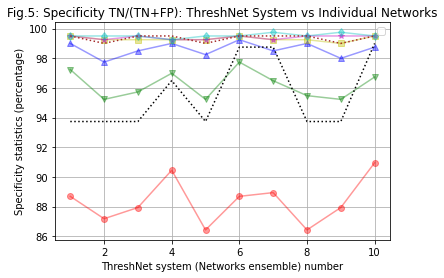

In [35]:
print(bestaccuracy_net_specificity)
print(bestsensitivity_net_specificity)
print(bestspecificity_net_specificity)

allSystemSpecificity = np.array(allSystemSpecificity)
print(allSystemSpecificity)
x = range(1, len(allSystemSpecificity)+1)

# system plot
for i in range(len(allSystemsLabels)):
    #plot(x, allSystemSpecificity[:, i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)
    plot(x, allSystemSpecificity[:, i], allSystemsMarkers[i], alpha=0.4)

#plot(x,bestaccuracy_net_specificity, color='orange', linestyle='dotted')#, label="ind. network w/ highest accuracy")
plot(x,bestsensitivity_net_specificity,color='black', linestyle='dotted')#,label="ind. network w/ highest sensitivity")
plot(x,bestspecificity_net_specificity, color='brown', linestyle='dotted')#,label="ind. network w/ highest specificity")

plt.grid()
plt.legend()
plt.title('Fig.5: Specificity TN/(TN+FP): ThreshNet System vs Individual Networks')
plt.xlabel('ThreshNet system (Networks ensemble) number')
plt.ylabel('Specificity statistics (percentage)')


[97.79661016949153, 98.64406779661017, 98.64406779661017, 97.6271186440678, 97.79661016949153, 97.79661016949153, 97.79661016949153, 97.11864406779661, 98.64406779661017, 98.64406779661017]
[95.25423728813558, 95.25423728813558, 95.25423728813558, 96.27118644067797, 95.25423728813558, 97.79661016949153, 97.79661016949153, 95.25423728813558, 95.25423728813558, 98.64406779661017]
[94.23728813559322, 97.28813559322033, 93.72881355932203, 95.59322033898306, 97.28813559322033, 94.23728813559322, 95.9322033898305, 95.59322033898306, 98.64406779661017, 93.72881355932203]
[[92.203 97.797 98.305 98.305 98.136 96.78 ]
 [91.356 96.271 97.797 98.475 98.136 98.136]
 [91.864 96.61  98.305 98.475 98.644 98.136]
 [93.22  97.288 98.136 98.305 97.797 97.288]
 [90.508 96.271 98.136 98.305 98.136 97.966]
 [91.864 97.627 98.475 98.305 97.797 96.949]
 [92.034 97.119 97.797 97.966 97.966 97.458]
 [90.508 96.441 98.475 98.305 97.797 97.119]
 [91.695 96.271 97.966 98.136 98.305 98.136]
 [93.729 97.119 98.136 9

Text(0, 0.5, 'Accuracy statistics (percentage)')

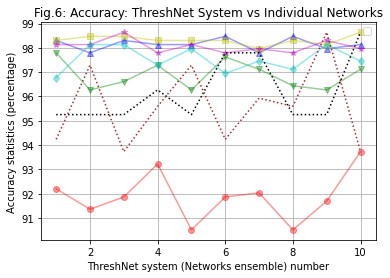

In [36]:
print(bestaccuracy_net_accuracy)
print(bestsensitivity_net_accuracy)
print(bestspecificity_net_accuracy)

allSystemAccs = np.array(allSystemAccs)
print(allSystemAccs)
#print(allSystemAccs-bestaccuracy_net_accuracy)

x = range(1, len(allAcc)+1)
for i in range(len(allSystemsLabels)):
#    plot(x, allSystemAccs[: , i], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)
    plot(x, allSystemAccs[: , i], allSystemsMarkers[i], alpha=0.4)

#plot(x,bestaccuracy_net_accuracy, color='orange', linestyle='dotted', label="ind. network w/ highest accuracy")
plot(x,bestsensitivity_net_accuracy, color='black', linestyle='dotted')#,label="ind. network w/ highest sensitivity")
plot(x,bestspecificity_net_accuracy, color='brown', linestyle='dotted')#,label="ind. network w/ highest specificity")


plt.grid()
plt.legend() 
plt.title('Fig.6: Accuracy: ThreshNet System vs Individual Networks')
plt.xlabel('ThreshNet system (Networks ensemble) number')
plt.ylabel('Accuracy statistics (percentage)')
    


(0.0, 100.0)

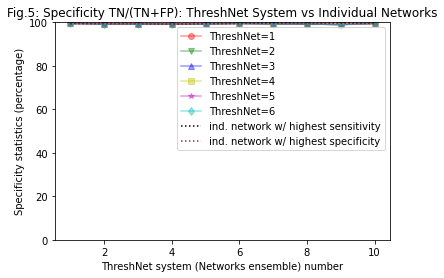

In [37]:
x = range(1, len(allSystemSpecificity)+1)

# system plot
for i in range(len(allSystemsLabels)):
    plot(x, allSystemSpecificity[:,3], allSystemsMarkers[i], label=allSystemsLabels[i], alpha=0.4)

#plot(x,bestaccuracy_net_specificity, color='orange', linestyle='dotted')#, label="ind. network w/ highest accuracy")
plot(x,allSystemSpecificity[:, 5],color='black', linestyle='dotted',label="ind. network w/ highest sensitivity")
plot(x,allSystemSpecificity[:, 5], color='brown', linestyle='dotted',label="ind. network w/ highest specificity")

plt.legend()
plt.title('Fig.5: Specificity TN/(TN+FP): ThreshNet System vs Individual Networks')
plt.xlabel('ThreshNet system (Networks ensemble) number')
plt.ylabel('Specificity statistics (percentage)')
plt.ylim((0,100))




In [38]:
"""
print("Wrong:")
numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(finalResult) - 1):
    if original[i] == 1 and finalResult[i] == 0:
        numFalseNegatives += 1
        print("False Negative ", i)
    if original[i] != finalResult[i]:
        numTotalWrong += 1
        print("Wrong ", i)
print("Number of false negatives in entire system")
print(numFalseNegatives)


print("Number total wrong in entire system")
print(numTotalWrong)
"""

'\nprint("Wrong:")\nnumFalseNegatives = 0\nnumTotalWrong = 0\nfor i in range(len(finalResult) - 1):\n    if original[i] == 1 and finalResult[i] == 0:\n        numFalseNegatives += 1\n        print("False Negative ", i)\n    if original[i] != finalResult[i]:\n        numTotalWrong += 1\n        print("Wrong ", i)\nprint("Number of false negatives in entire system")\nprint(numFalseNegatives)\n\n\nprint("Number total wrong in entire system")\nprint(numTotalWrong)\n'

In [39]:
numWrong = 0
numFalseNegatives = 0

for i in range(len(finalResult) - 1):
    if original[i] == 1 and finalResult[i] == 0:
        """print("FALSE NEGATIVE")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print("INCORRECT")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print(allPreds[0][i])
        print(allPreds[1][i])
        print(allPreds[2][i])
        print("system's decision: ", finalResult[i])
        print("correct answer: ", original[i])
        """
        print("False Negative: ", i)
        
        ####
        
        numWrong += 1
        numFalseNegatives += 1
    if original[i] == 0 and finalResult[i] == 1:     
        """print("INCORRECT")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print(allPreds[0][i])
        print(allPreds[1][i])
        print(allPreds[2][i])
        print("system's decision: ", finalResult[i])
        print("correct answer: ", original[i])
        """
       # print("False Positive: ", i)
        numWrong += 1 
        
print("Num false negatives:", numFalseNegatives)
print("Num wrong", numWrong)
  

False Negative:  27
False Negative:  99
False Negative:  106
False Negative:  152
False Negative:  255
False Negative:  256
False Negative:  321
False Negative:  335
False Negative:  344
False Negative:  374
False Negative:  451
False Negative:  477
False Negative:  486
Num false negatives: 13
Num wrong 15


# 7: CLASSIFIACTION MODEL EVALUATION

In [40]:
 #h.history.keys()

In [41]:
"""plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);"""

'plt.figure(figsize=(12,5))\nplt.subplot(1,2,1)\nplt.plot(h.history[\'loss\']);\nplt.plot(h.history[\'val_loss\']);\nplt.title("Classification Model LOSS");\nplt.ylabel("loss");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);\n\nplt.subplot(1,2,2)\nplt.plot(h.history[\'accuracy\']);\nplt.plot(h.history[\'val_accuracy\']);\nplt.title("Classification Model Acc");\nplt.ylabel("Accuracy");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);'

In [42]:
"""_, acc = loaded_model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))
"""

'_, acc = loaded_model.evaluate(test_generator)\nprint("Test accuracy : {} %".format(acc*100))\n'

In [43]:
"""
prediction = loaded_model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
print(original)
print(pred)

finalResult = [[]] 
for i in range (len(predCombined)-1):
    if predCombined[i] == 0: 
        finalResult[0].append(0)
    else:
        finalResult[0].append(1)
for j in range (len(pred)-1):
    if pred[i] == 0:
        finalResult[1].append(0)
    else:
        finalResult[1].append(1)
print(finalResult)
"""

"\nprediction = loaded_model.predict(test_generator)\n\npred = np.argmax(prediction, axis=1)\n#pred = np.asarray(pred).astype('str')\noriginal = np.asarray(test['mask']).astype('int')\n\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\naccuracy = accuracy_score(original, pred)\nprint(accuracy)\n\ncm = confusion_matrix(original, pred)\n\nreport = classification_report(original, pred, labels = [0,1])\nprint(report)\nplt.figure(figsize = (5,5))\nsns.heatmap(cm, annot=True);\nprint(original)\nprint(pred)\n\nfinalResult = [[]] \nfor i in range (len(predCombined)-1):\n    if predCombined[i] == 0: \n        finalResult[0].append(0)\n    else:\n        finalResult[0].append(1)\nfor j in range (len(pred)-1):\n    if pred[i] == 0:\n        finalResult[1].append(0)\n    else:\n        finalResult[1].append(1)\nprint(finalResult)\n"

In [44]:
for i in range(len(original)):
    if original[i] == 1 and predCombined[i] == 0:
        print("false negative", i)
    if original[i] == 0 and predCombined[i] == 1:
        print("false positive", i)
        

KeyError: 0

# 8: BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [45]:
""" 
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-45-ef98358dfd85>, line 3)

In [46]:
""" # creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-46-2309b6b58865>, line 10)

In [47]:
""" class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-47-7cc73b99becb>, line 93)

![alt text](https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH)

![alt text](https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD)

In [48]:
""" # lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-48-2f186fce5f78>, line 33)

In [49]:
""" input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-49-f58a9e597162>, line 46)

# 9: TRAINING SEGMENTATION MODEL

In [50]:
""" # Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-50-421f81c8f4ef>, line 28)

In [51]:
"""# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-51-0594f68272b0>, line 24)

In [52]:
""" h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-52-0b88012fb48a>, line 5)

In [53]:
""" # saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-53-bd66baed6392>, line 4)

# 10: SEGMENTATION MODEL EVALUATION

In [54]:
"""h.history.keys()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-54-004194117380>, line 1)

In [55]:
"""plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-55-c827e1b6c560>, line 16)

In [56]:
"""test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-56-ca7ad08051f0>, line 5)

# 11: SEGMENTATION MODEL PREFORMACE 
## (COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [57]:
"""def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-57-6a6ab3971c37>, line 62)

In [58]:
"""# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-58-718bf20f3314>, line 3)

In [59]:
"""# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-59-3a90d3f217c5>, line 3)

In [60]:
"""#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-60-726ff537e068>, line 39)